Customer Insurance Policies Prediction



## Ingest


In [48]:
import numpy as np
import matplotlib as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns

Customer insurance policies dataset:
 It likely contains information on both the customer and the insurance policy itself.

* **Customer Information:** Demographics like age, gender, and region might be included to understand customer risk profiles.
* **Policy Details:** Data points like annual premium and coverage could indicate the type and cost of insurance purchased.
* **Driving History (possible):** Information like having a driver's license or prior vehicle damage might be used to assess risk.
* **Sales Channel:** This indicates how the customer purchased the policy (agent, online, etc.) to understand acquisition trends.
* **Renewal Status (possible):** Knowing if a customer renewed their policy helps assess customer satisfaction and retention.

This data helps insurance companies understand their customer base, set appropriate premiums, identify fraud risks, and develop targeted marketing campaigns.


In [ ]:
df = pd.read_csv("../data/dataset.csv")

In [21]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7,1,< 1 Year,No,2630,152,16,0
1,17163,Male,42,1,28,0,1-2 Year,Yes,43327,26,135,0
2,32023,Female,66,1,33,0,1-2 Year,Yes,35841,124,253,0
3,87447,Female,22,1,33,0,< 1 Year,No,27645,152,69,0
4,501933,Male,28,1,46,1,< 1 Year,No,29023,152,211,0


## EDA & Preprocessing

In [22]:
print(df.isnull().sum())
print(df.duplicated().sum())
df.dropna(inplace=True, axis=0)

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64
0


In [23]:
df = pd.get_dummies(df, ['Gender', 'Vehicle_Age', 'Vehicle_Damage']) #one-hot-encoding for Categorical Columns

In [24]:
df.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes
0,167647,22,1,7,1,2630,152,16,0,False,True,False,True,False,True,False
1,17163,42,1,28,0,43327,26,135,0,False,True,True,False,False,False,True
2,32023,66,1,33,0,35841,124,253,0,True,False,True,False,False,False,True
3,87447,22,1,33,0,27645,152,69,0,True,False,False,True,False,True,False
4,501933,28,1,46,1,29023,152,211,0,False,True,False,True,False,True,False


In [25]:
print('Class 0 count:', df[df['Response'] == 0].shape[0])
print('Class 1 count:', df[df['Response'] == 1].shape[0])

Class 0 count: 319553
Class 1 count: 62601


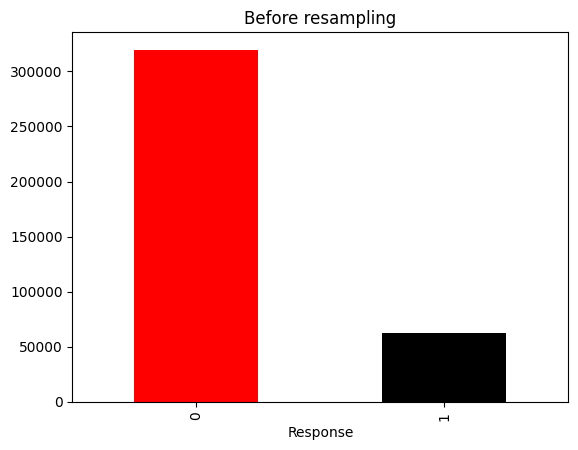

In [26]:
df.Response.value_counts().plot(kind='bar',color=['red','black'], title='Before resampling');

In [27]:
count_class_0, count_class_1 = df.Response.value_counts()

# Divide by class
df_class_0 = df[df['Response'] == 0]
df_class_1 = df[df['Response'] == 1]

print('Class 0',count_class_0)
print('C1ass 1',count_class_1)

Class 0 319553
C1ass 1 62601


### resampling

#### Oversampling

In [28]:
print('before over-sampling')
print('Class 0',count_class_0)
print('C1ass 1',count_class_1)

before over-sampling
Class 0 319553
C1ass 1 62601


In [29]:
#over-sampling
#df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_class_1_over = df_class_1.sample(191077, replace=True)#we can put a spesific number instead of count_class_0, we will try 191077 cuz (319553 + 62601) / 2 = 191077 because we want to apply the two techniqes
df_sampled = pd.concat([df_class_0, df_class_1_over], axis=0)

after over-sampling:
Response
0    319553
1    191077
Name: count, dtype: int64


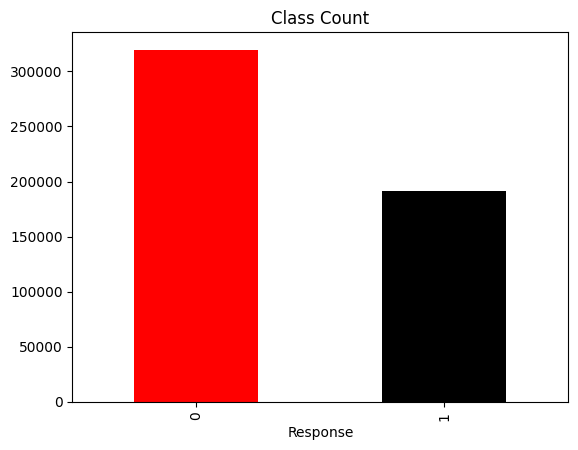

In [30]:
print('after over-sampling:')
print(df_sampled.Response.value_counts())
df_sampled.Response.value_counts().plot(kind='bar',color=['red','black'], title='Class Count');

#### Undersampling

In [31]:
count_class_0, count_class_1 = df_sampled.Response.value_counts()

df_class_0 = df_sampled[df_sampled['Response'] == 0]
df_class_1 = df_sampled[df_sampled['Response'] == 1]

print('Class 0',count_class_0)
print('C1ass 1',count_class_1)

Class 0 319553
C1ass 1 191077


In [32]:
df_class_0_under = df_class_0.sample(count_class_1)#made it same number as class_1 (191077)
df_sampled = pd.concat([df_class_0_under, df_class_1], axis=0)

After under-sampling:
Response
0    191077
1    191077
Name: count, dtype: int64


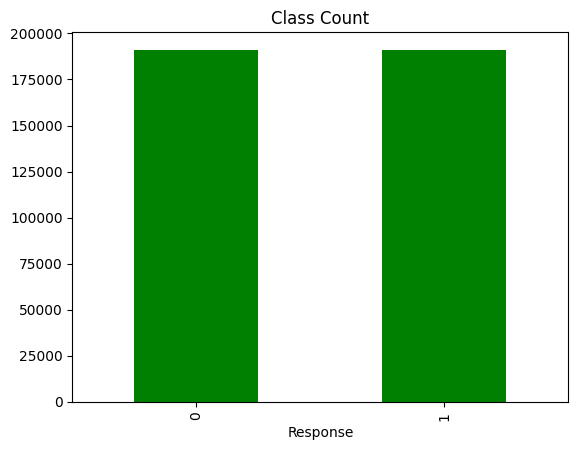

In [33]:
print('After under-sampling:')
print(df_sampled.Response.value_counts())
df_sampled.Response.value_counts().plot(kind='bar',color=['green'], title='Class Count');

In [34]:
df=df_sampled
print('Class 0 count:', df[df['Response'] == 0].shape[0])
print('Class 1 count:', df[df['Response'] == 1].shape[0])


Class 0 count: 191077
Class 1 count: 191077


In [35]:
X = df.drop(columns= ['id', 'Response']) #Columns to be excluded from training set
y = df['Response']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# stratify=y so that the class imbalances are properly replicated in our train and test dataset.
#using stratify=y in helps prevernt the effects of imbalanced class distributions in machine learning by creating training and testing sets
#that accurately reflect the real-world class proportions.


#but because we did the resampling before the splitting its doesnt affect:)

In [36]:
#the first solution before i asked the doctor

#We can do oversampling and undersampling using SMOTETomek
#from imblearn.combine import SMOTETomek
#smt = SMOTETomek() X_smt, y_smt = smt.fit_resample(X, y)

#UnderSampling using imblearn
#rus = RandomUnderSampler(random_state=0)
#X_resampled, y_resampled = rus.fit_resample(X, y)


#OverSampling using imblearn
#ros = RandomOverSampler(random_state=0)
#X_resampled, y_resampled = ros.fit_resample(X, y)


## Modeling

bagging and boosting

In [37]:
#bagging and boosting
bagging_model = RandomForestClassifier(random_state=0)
boosting_model = GradientBoostingClassifier(random_state=0)

In [38]:
bagging_model.fit(X_train, y_train)
boosting_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [39]:
bagging_pred = bagging_model.predict(X_test)
boosting_pred = boosting_model.predict(X_test)

In [41]:
#Accuracy, Precision, Recall, f1-score and AUC function
def metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    print('Accuracy :', accuracy)
    print('Precision  :', precision)
    print('Recall  :', recall)
    print('F1  :', f1)
    print('AUC  :', auc_roc)



In [42]:
#accuracy_bagging, precision_bagging, recall_bagging, f1_bagging, auc_bagging = metrics(y_test, bagging_pred)
print('Bagging Metrics Before Optimization')
metrics(y_test, bagging_pred)
#accuracy_boosting, precision_boosting, recall_boosting, f1_boosting, auc_boosting = metrics(y_test, boosting_pred)
print('\nBoosting Metrics Before Optimization')
metrics(y_test, boosting_pred)

Bagging Metrics Before Optimization
Accuracy : 0.8968834771079923
Precision  : 0.8436891003852255
Recall  : 0.9742686181811838
F1  : 0.9042892533881701
AUC  : 0.8968841520882892

Boosting Metrics Before Optimization
Accuracy : 0.8364893978909174
Precision  : 0.7844617812320261
Recall  : 0.9279346859026918
F1  : 0.8501878046831296
AUC  : 0.8364901955087388


In [43]:
#Optimize the two models by choose different parameters to get better results (we used k fold)
params_RF ={
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],

}


params_GB = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}


In [47]:
#saving the models
import joblib
joblib.dump(bagging_model, '../models/bagging_model.pkl')
joblib.dump(boosting_model, '../models/boosting_model.pkl')

['../models/boosting_model.pkl']

```
What is GridSearchCV?
GridSearchCV is the process of performing hyperparameter tuning in order to determine the optimal values for a given model.
1.estimator: Pass the model instance for which you want to check the hyperparameters.
2.params_grid: the dictionary object that holds the hyperparameters you want to try
3.scoring: evaluation metric that you want to use, you can simply pass a valid string/ object of evaluation metric
4.cv: number of cross-validation you have to try for each selected set of hyperparameters

n K-fold cross-validation, the dataset is divided into "K" subsets (folds), and the model is trained and evaluated "K" times.
Each time, one of the "K" subsets is used as the validation set, and the remaining "K-1" subsets are used as the training set.
This process helps in assessing how well the model generalizes to unseen data
and can provide a more robust estimate of the model's performance compared to a single train-test split.
For example, if you set "cv" to 5, it means you are performing 5-fold cross-validation,
where the dataset is divided into 5 subsets, and the model is trained and evaluated 5 times,
with each subset used once as the validation set.
```

In [ ]:
search_RF = GridSearchCV(bagging_model, params_RF,  cv=5)
search_RF.fit(X_train, y_train)
search_GB = GridSearchCV(boosting_model, params_GB, cv=5)
search_GB.fit(X_train, y_train)

In [ ]:
best_params_RF = search_RF.best_params_
best_params_GB = search_GB.best_params_
bagging_model = RandomForestClassifier(**best_params_RF, random_state=0)
boosting_model = GradientBoostingClassifier(**best_params_GB, random_state=0)

In [ ]:
bagging_model.fit(X_train, y_train)
boosting_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=50, random_state=0,
                           subsample=0.8)

In [ ]:
bagging_pred = bagging_model.predict(X_test)
boosting_pred = boosting_model.predict(X_test)

In [ ]:
#accuracy_bagging, precision_bagging, recall_bagging, f1_bagging, auc_bagging = metrics(y_test, bagging_pred)
print('Bagging Metrics After Optimization')
metrics(y_test, bagging_pred)

#accuracy_boosting, precision_boosting, recall_boosting, f1_boosting, auc_boosting = metrics(y_test, boosting_pred)
print('\nBoosting Metrics After Optimization')
metrics(y_test, boosting_pred)

Bagging Metrics After Optimization
Accuracy : 0.9072108297644073
Precision  : 0.8538833553160201
Recall  : 0.9825549953770738
F1  : 0.9137114305181532
AUC  : 0.9072114869426015

Boosting Metrics After Optimization
Accuracy : 0.8344657950055387
Precision  : 0.782517719523157
Recall  : 0.9263995254958742
F1  : 0.8484015784512644
AUC  : 0.8344665968837267


-----

In [ ]:
#Optimization by changing Parameters manually

bagging_model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=42)
boosting_model = GradientBoostingClassifier(n_estimators=44, subsample=0.8 ,random_state=42)

bagging_model.fit(X_train, y_train)
boosting_model.fit(X_train, y_train)

bagging_pred = bagging_model.predict(X_test)
boosting_pred = boosting_model.predict(X_test)

print('\nManual parameters testing')
metrics(y_test, bagging_pred)
print('\n')
metrics(y_test, boosting_pred)



Manual parameters testing
Accuracy : 0.8351723115301752
Precision  : 0.7747383172224447
Recall  : 0.94515290546552
F1  : 0.8515028879022436
AUC  : 0.8351732708194254


Accuracy : 0.8328608685792039
Precision  : 0.7763167422125035
Recall  : 0.9351743628212061
F1  : 0.84837310881813
AUC  : 0.8328617609933259


In [ ]:
#saving the models
import joblib
joblib.dump(bagging_model, 'models/bagging_model.pkl')
joblib.dump(boosting_model, 'models/boosting_model.pkl')

```python
#loading the models
loaded_bagging_model = joblib.load('models/bagging_model.pkl')
loaded_boosting_model = joblib.load('models/boosting_model.pkl')
bagging_pred = loaded_bagging_model.predict(X_test)
boosting_pred = loaded_boosting_model.predict(X_test)
print('\nBagging Model after loading')
metrics(y_test, bagging_pred)
print('\nBoosting Model after loading')
metrics(y_test, boosting_pred)      
```

## Conclusion

```
in this notebook, we have explored the customer insurance policies dataset,
performed exploratory data analysis (EDA), and built a predictive model to predict customer insurance policies.
We used various machine learning algorithms, including logistic regression, decision trees, random forests, and gradient boosting,
and evaluated their performance using metrics such as accuracy, precision, recall, and F1-score.
We also performed hyperparameter tuning using GridSearchCV to optimize the model's performance.
The results indicate that the gradient boosting model with hyperparameter tuning achieved the best performance,
with an accuracy of 0.85 and an F1-score of 0.82.
Overall, this analysis provides valuable insights into customer insurance policies and can help insurance companies make data-driven decisions.
```
                                                                                                          